# MCTS pour Reversi 8x8

In [1]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from Reversi import Board

test_path = os.path.join("tests")

# Visualisation des tests

L'ensemble des tests sont stockés dans le dossier `tests`.

Le nom des tests désigne:
- `cls`: MCTS "classique" avec estimateur de gain sous forme de moyenne des gains cumulés.
- `har`: MCTS avec estimateur de gain calculé sous forme de moyenne harmonique.
- `cf<valeur>`: MCTS avec estimateur de gain calculé sous forme d'intervalle de confiance avec constante d'exploration `<valeur>`$.10^{-1}$.
- `rand`: jeu aléatoire uniforme.

Le premier nom dans chaque fichier de test est alors le joueur noir, le deuxième le joueur blanc.

## Estimateurs de gain utilisés pour le choix d'action $a$

Soit $r$ la récompense obtenue par "roll-out", $n_{s,a}$ le nombre de visite d'un noeud.

`cls`: $a^* = argmax (~\hat{\mu}_{s,a,t-1} + \frac{r - \hat{\mu}_{s,a,t-1}}{n_{s, a}})$

`har`: $a^* = argmax (~\frac{Victoires(s,a) + 1}{Pertes(s, a) + 2})$

`cf<valeur>`: $a^* = argmax (~\hat{\mu}_{s,a,t-1} + \sqrt{C_e \frac{\log{n_s}}{n_{s, a}})}$ avec $C_e =$ `<valeur>`

In [2]:
res_files = [f for f in os.listdir(test_path) if os.path.isfile(os.path.join(test_path, f))]

In [3]:
results = {}
for file in res_files:
    name = file.split('.')[0]
    with open(os.path.join(test_path, file), 'r') as f:
        results[name] = json.load(f)
        
all_moves = {players: [match["moves"] for match in matches] for players, matches in results.items()}
all_outcomes = {players: 
                {players.split('-')[0]: [match["outcome"][1] for match in matches], 
                 players.split('-')[1]: [match["outcome"][0] for match in matches]} 
                for players, matches in results.items()}

## Déroulement des parties

Si le widget interactif ci-dessous n'est pas disponible dans JupyterLab, utilisez les commandes suivantes dans votre environnement virtuel:

```bash
pip install ipywidgets
jupyter nbextension enable --py widgetsnbextension
jupyter labextension install @jupyter-widgets/jupyterlab-manager
```

puis relancez JupyterLab.

Les joueurs doivent être choisis parmi les noms de fichier test.
Le slider `match` permet de sélectionner une partie, le slider `turn` permet de sélectionner une manche au cours de la partie.

In [4]:
players = "cls-rand" #cls-har #har-rand #cls-cf01

moves = all_moves[players]

def watch(moves, match, turn):
    m = moves[match]
    b = Board()
    for t in range(turn):
        b.push(m[t])
    display(b)

w = interact(watch,
         match=widgets.IntSlider(min=0, max=len(moves)-1, step=1, value=0), 
         turn=widgets.IntSlider(min=0, max=60, step=1, value=0), 
         moves=fixed(moves))

interactive(children=(IntSlider(value=0, description='match', max=29), IntSlider(value=0, description='turn', …

# Performances face au hasard

On évalue les performances des différents algorithmes utilisés face à un joueur effectuant un choix d'action aléatoire à chaque tour. Le plateau étant composé de 64 cases, on définit le seuil de victoire minimal d'une couleur à 33 pions. Le score représente le nombre de pions d'une même couleur posés sur le plateau. Un score proche de 60 signifie donc une victoire écrasante.

In [5]:
all_players = [
    "cls-rand",
    "har-rand",
    "cf005-rand",
    "cf01-rand"
]

rand_outcomes = [
    all_outcomes[p] for p in all_players
]

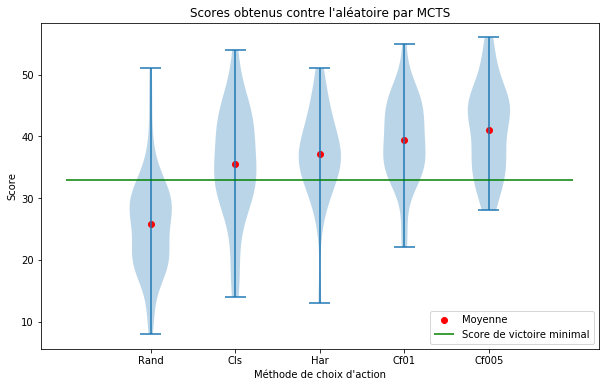

In [6]:
random_score = np.array([res["rand"] for res in rand_outcomes]).ravel()
cls_score = np.array(all_outcomes["cls-rand"]["cls"]).ravel()
har_score = np.array(all_outcomes["har-rand"]["har"]).ravel()
cf01_score = np.array(all_outcomes["cf01-rand"]["cf01"]).ravel()
cf005_score = np.array(all_outcomes["cf005-rand"]["cf005"]).ravel()

data = [random_score, cls_score, har_score, cf01_score, cf005_score]
means = list(map(np.mean, data))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot((111))
ax.set_title("Scores obtenus contre l'aléatoire par MCTS")
ax.set_xticks(np.arange(1, len(data)+1))
ax.set_xticklabels(["Rand", "Cls", "Har", "Cf01", "Cf005"])
ax.set_xlabel("Méthode de choix d'action")
ax.set_ylabel("Score")

violin = ax.violinplot((random_score, cls_score, har_score, cf01_score, cf005_score))
means = ax.scatter(range(1, len(means)+1), means, color='r', label="Moyenne")
victory = ax.hlines(y=33, xmin=0, xmax=6, color='g', label="Score de victoire minimal")

l = ax.legend(loc="lower right")

On constate que MCTS surpasse l'aléatoire dans quasiment toutes les situations. La moyenne des scores se trouve au dessu du seuil de victoire, et certaines techniques comme le MCTS `cf005` démontrent également une répartition des scores ramassée autour de scores relativmement importants. De plus, on observe que l'utilisation de méthodes de calculs plus complexes pour le choix de l'action apporte une amélioration globale du score obtenu contre l'aléatoire. Les méthodes avec constante d'exploration semblent particulièrement efficaces.

# Performances de MCTS avec estimateur de gain en fonction de la constante d'exploration $C_e$

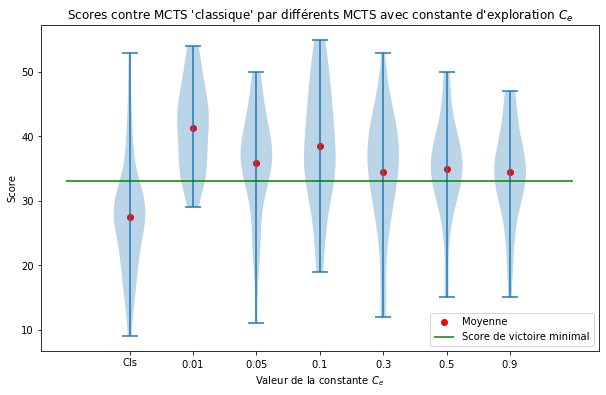

In [20]:
all_players = [
    "cls-cf001",
    "cls-cf005",
    "cls-cf01",
    "cls-cf03",
    "cls-cf05",
    "cls-cf09"
]

cls_outcomes = [
    all_outcomes[p] for p in all_players
]

cls_score = np.array([res["cls"] for res in cls_outcomes]).ravel()
cf001 = np.array(all_outcomes["cls-cf001"]["cf001"]).ravel()
cf005 = np.array(all_outcomes["cls-cf005"]["cf005"]).ravel()
cf01 = np.array(all_outcomes["cls-cf01"]["cf01"]).ravel()
cf03 = np.array(all_outcomes["cls-cf03"]["cf03"]).ravel()
cf05 = np.array(all_outcomes["cls-cf05"]["cf05"]).ravel()
cf09 = np.array(all_outcomes["cls-cf09"]["cf09"]).ravel()


data = [cls_score, cf001, cf005, cf01, cf03, cf05, cf09]
means = list(map(np.mean, data))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot((111))
ax.set_title("Scores contre MCTS 'classique' par différents MCTS avec constante d'exploration $C_e$")
ax.set_xticks(np.arange(1, len(data)+1))
ax.set_xticklabels(["Cls", "$0.01$", "$0.05$", "$0.1$", "$0.3$", "$0.5$", "$0.9$"])
ax.set_xlabel("Valeur de la constante $C_e$")
ax.set_ylabel("Score")

violin = ax.violinplot(data)
means = ax.scatter(range(1, len(means)+1), means, color='r', label="Moyenne")
victory = ax.hlines(y=33, xmin=0, xmax=8, color='g', label="Score de victoire minimal")

l = ax.legend(loc="lower right")

On constate qu'une constante d'exploration de plus faible valeur permet d'obtenir des scores plus importants, et avec un risque d'echec plus faible.

# Discussion

L'ensemble de ces résultats a été obtenu sur 30 matchs consécutifs entre chaque couple de test. Un nombre plus important de match permettrait d'obtenir des résultats plus concluants.

L'utilisation d'une constante d'exploration pour le choix des actions semblent être la meilleure alternative testée. Cette constante doit cependant être relativement faible en valeur pour apporter une amélioration significative par rapport au MCTS "classique". Cette constante permet en effet de donner plus de poids relatif à des noeuds faiblement explorés dans l'arbre. Cette méthode permet ainsi d'explorer plus de possibilités, cependant au détriment potentiel de l'exploitation d'une solution optimale.